In [1]:
import os
import logging
import subprocess
import psutil
import resource
# memory_limit = 20 * 1024 * 1024 * 1024
# resource.setrlimit(resource.RLIMIT_AS, (memory_limit, memory_limit))


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, message=".*OldFormatWarning.*")

import numpy as np
import pandas as pd
import scipy as sp

import matplotlib.pyplot as plt
from matplotlib import rcParams, colors
import seaborn as sb

import omicverse as ov
import scanpy as sc
import scanorama
import scib
import scvi


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.10, Tutorials: https://omicverse.readthedocs.io/


/home/data/t050502/miniconda3/envs/omicverse/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/data/t050502/miniconda3/envs/omicverse/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/data/t050502/miniconda3/envs/omicverse/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/data/t050502/miniconda3/envs/omicverse/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/data/t050502/miniconda3/envs/omicverse/lib/p

In [2]:
import omicverse as ov
print(f"omiverse version: {ov.__version__}")
import scanpy as sc
print(f"scanpy version: {sc.__version__}")
import scvi
print(f"scvi version: {scvi.__version__}")
import scib
print(f"scib version: {scib.__version__}")
# ov.ov_plot_set()

omiverse version: 1.6.10
scanpy version: 1.10.4
scvi version: 1.3.0
scib version: 1.1.7


In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import warnings
import os
import subprocess

warnings.simplefilter(action='ignore', category=Warning)

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3             

sc.settings.set_figure_params(dpi=80)
%matplotlib inline

In [4]:
# download pre-computed data if missing or long compute
fetch_data = True

# url for source and intermediate data
path_data = "https://nextcloud.dc.scilifelab.se/public.php/webdav"
curl_upass = "zbC5fr2LbEZ9rSE:scRNAseq2025"


path_results = "../Data/covid/results"
if not os.path.exists(path_results):
    os.makedirs(path_results, exist_ok=True)

path_file = "../Data/covid/results/scanpy_covid_qc_dr.h5ad"
if fetch_data and not os.path.exists(path_file):
    file_url = os.path.join(path_data, "covid/results_scanpy/scanpy_covid_qc_dr.h5ad")
    subprocess.call(["curl", "-u", curl_upass, "-o", path_file, file_url ])

adata = sc.read_h5ad(path_file)
adata

AnnData object with n_obs × n_vars = 7332 × 2656
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'doublet_info_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'phase_colors', 'sample_colors', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
print(adata.X.shape)

(7332, 2656)


In [6]:
# First store the old set of hvgs
var_genes_all = adata.var.highly_variable
print("Highly variable genes: %d"%sum(var_genes_all))

adata = adata.raw.to_adata() 

# in some versions of Anndata there is an issue with information on the logtransformation in the slot log1p.base so we set it to None to not get errors.
adata.uns['log1p']['base']=None

# check that the matrix looks like normalized counts
print(adata.X[1:10,1:10])

Highly variable genes: 2656
  (0, 3)	1.479703103222477
  (7, 6)	1.6397408237842532


In [7]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key = 'sample')

print("Highly variable genes intersection: %d"%sum(adata.var.highly_variable_intersection))

print("Number of batches where gene is variable:")
print(adata.var.highly_variable_nbatches.value_counts())

var_genes_batch = adata.var.highly_variable_nbatches > 0

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Highly variable genes intersection: 83
Number of batches where gene is variable:
highly_variable_nbatches
0    6760
1    5164
2    3560
3    2050
4    1003
5     487
6     228
7     133
8      83
Name: count, dtype: int64


In [8]:
print("Any batch var genes: %d"%sum(var_genes_batch))
print("All data var genes: %d"%sum(var_genes_all))
print("Overlap: %d"%sum(var_genes_batch & var_genes_all))
print("Variable genes in all batches: %d"%sum(adata.var.highly_variable_nbatches == 6))
print("Overlap batch instersection and all: %d"%sum(var_genes_all & adata.var.highly_variable_intersection))

Any batch var genes: 12708
All data var genes: 2656
Overlap: 2654
Variable genes in all batches: 228
Overlap batch instersection and all: 83


In [9]:
var_select = adata.var.highly_variable_nbatches > 2
var_genes = var_select.index[var_select]
len(var_genes)

3984

In [10]:
# first store again the full matrix to the raw slot.
adata.raw = adata
adata = adata[:,var_genes]

sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50
    finished (0:00:14)


In [11]:
adata.obsm['X_umap_uncorr'] = adata.obsm['X_umap']
adata.obsm['X_tsne_uncorr'] = adata.obsm['X_tsne']

**`reference pipeline `**

from https://nbisweden.github.io/workshop-scRNAseq/labs/scanpy/scanpy_03_integration.html#meta-int_scanorama

In [12]:
# first store again the full matrix to the raw slot.
adata.raw = adata
adata = adata[:,var_genes]

sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')

# split per batch into new objects.
batches = adata.obs['sample'].cat.categories.tolist()
alldata = {}
for batch in batches:
    alldata[batch] = adata[adata.obs['sample'] == batch,]

alldata   

computing PCA
    with n_comps=50
    finished (0:00:13)


{'covid_1': View of AnnData object with n_obs × n_vars = 888 × 3984
     obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
     var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
     uns: 'doublet_info_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'phase_colors', 'sample_colors', 'tsne', 'umap'
     obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_umap_uncorr', 'X_tsne_uncorr'
     varm: 'PCs'
     obsp: 'connectivities', 'distances',
 'covid_15': View of AnnData object with n_obs

In [13]:
import scanorama

#subset the individual dataset to the variable genes we defined at the beginning
alldata2 = dict()
for ds in alldata.keys():
    print(ds)
    alldata2[ds] = alldata[ds][:,var_genes]

#convert to list of AnnData objects
adatas = list(alldata2.values())

# run scanorama.integrate
scanorama.integrate_scanpy(adatas, dimred = 50)

#scanorama adds the corrected matrix to adata.obsm in each of the datasets in adatas.
adatas[0].obsm['X_scanorama'].shape

# Get all the integrated matrices.
scanorama_int = [ad.obsm['X_scanorama'] for ad in adatas]

# make into one matrix.
all_s = np.concatenate(scanorama_int)
print(all_s.shape)

# add to the AnnData object, create a new object first
adata.obsm["Scanorama"] = all_s

covid_1
covid_15
covid_16
covid_17
ctrl_5
ctrl_13
ctrl_14
ctrl_19
Found 3984 genes among all datasets
[[0.         0.60601002 0.61185984 0.31009174 0.54842342 0.5777027
  0.49211712 0.19256757]
 [0.         0.         0.76280323 0.44240401 0.44754572 0.27378965
  0.38397329 0.25208681]
 [0.         0.         0.         0.32614555 0.50943396 0.53638814
  0.45552561 0.28571429]
 [0.         0.         0.         0.         0.31183831 0.12477064
  0.2293578  0.26146789]
 [0.         0.         0.         0.         0.         0.89412897
  0.71126083 0.30381944]
 [0.         0.         0.         0.         0.         0.
  0.85615251 0.49565972]
 [0.         0.         0.         0.         0.         0.
  0.         0.79079861]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]
Processing datasets (4, 5)
Processing datasets (5, 6)
Processing datasets (6, 7)
Processing datasets (1, 2)
Processing datasets (4, 6)
Processing datasets (0, 2)
Processing datas

**`used pipline`**

In [12]:
adata.layers["counts"] = adata.X.copy()
adata = adata[:,var_genes]

# 将数据按 batch 分开
batches = adata.obs['sample'].cat.categories.tolist()
alldata = {}
for batch in batches:
    print(batch)
    alldata[batch] = adata[adata.obs['sample'] == batch, :]

adatas = list(alldata.values())
scanorama.integrate_scanpy(adatas, dimred=50)
scanorama_int = [ad.obsm['X_scanorama'] for ad in adatas]
all_s = np.concatenate(scanorama_int)

adata.obsm["X_scanorama"] = all_s

print(adata.obsm["X_scanorama"].shape)

covid_1
covid_15
covid_16
covid_17
ctrl_5
ctrl_13
ctrl_14
ctrl_19
Found 3984 genes among all datasets
[[0.         0.60601002 0.61185984 0.31009174 0.54842342 0.5777027
  0.49211712 0.19256757]
 [0.         0.         0.76280323 0.44240401 0.44754572 0.27378965
  0.38397329 0.25208681]
 [0.         0.         0.         0.32614555 0.50943396 0.53638814
  0.45552561 0.28571429]
 [0.         0.         0.         0.         0.31183831 0.12477064
  0.2293578  0.26146789]
 [0.         0.         0.         0.         0.         0.89412897
  0.71126083 0.30381944]
 [0.         0.         0.         0.         0.         0.
  0.85615251 0.49565972]
 [0.         0.         0.         0.         0.         0.
  0.         0.79079861]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]
Processing datasets (4, 5)
Processing datasets (5, 6)
Processing datasets (6, 7)
Processing datasets (1, 2)
Processing datasets (4, 6)
Processing datasets (0, 2)
Processing datas

**`visualize the data`**

In [16]:
np.array_equal(adata.obsm["X_scanorama"], adata.obsm["Scanorama"])

True

computing neighbors
    finished: added to `.uns['ref_scanorama_neighbours']`
    `.obsp['ref_scanorama_neighbours_distances']`, distances for each pair of neighbors
    `.obsp['ref_scanorama_neighbours_connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:10)


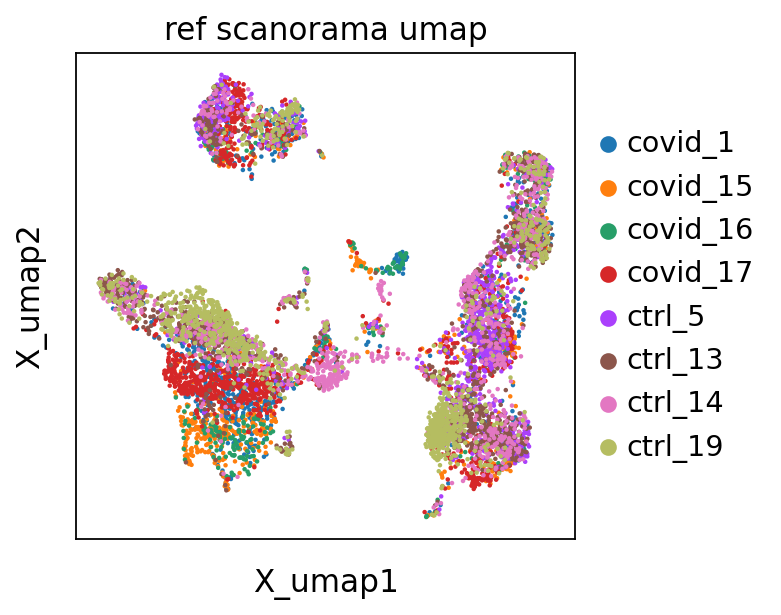

In [15]:
# umap
sc.pp.neighbors(adata, n_pcs =30, use_rep = "Scanorama",key_added='ref_scanorama_neighbours')
sc.tl.umap(adata, neighbors_key='ref_scanorama_neighbours')
sc.pl.embedding(adata, 'X_umap', color="sample", title="ref scanorama umap", show=True)

computing neighbors
    finished: added to `.uns['scanorama_neighbours']`
    `.obsp['scanorama_neighbours_distances']`, distances for each pair of neighbors
    `.obsp['scanorama_neighbours_connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:14)


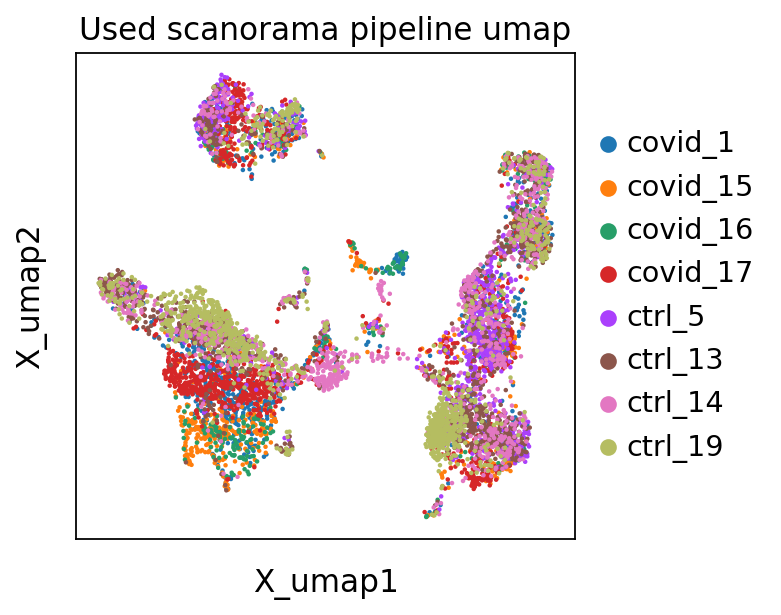

In [17]:
# umap
sc.pp.neighbors(adata, n_pcs =30, use_rep = "X_scanorama",key_added='scanorama_neighbours')
sc.tl.umap(adata, neighbors_key='scanorama_neighbours')
sc.pl.embedding(adata, 'X_umap', color="sample", title="Used scanorama pipeline umap", show=True)

pipeline used for immune integration

In [16]:
adata = sc.read_h5ad('../Data/Immune_human_mouse/human_alldata_qc.h5ad')
adata_scanorama=adata.copy()
# ov.single.batch_correction(adata_scanorama,batch_key='batch',
#                                         methods='scanorama',n_pcs=50)

In [17]:
adata_scanorama.layers["counts"] = adata_scanorama.X.copy()

# 将数据按 batch 分开
batches = adata_scanorama.obs['batch'].cat.categories.tolist()
alldata = {}
for batch in batches:
    alldata[batch] = adata_scanorama[adata_scanorama.obs['batch'] == batch, :]

adatas = list(alldata.values())
scanorama.integrate_scanpy(adatas, dimred=30)
scanorama_int = [ad.obsm['X_scanorama'] for ad in adatas]
all_s = np.concatenate(scanorama_int)

adata_scanorama.obsm["X_scanorama"] = all_s

Found 8128 genes among all datasets
[[0.         0.10176991 0.20489443 0.00587544 0.02766136 0.01071668
  0.00343249 0.00170068 0.00555556 0.26027397]
 [0.         0.         0.00884956 0.00379267 0.01201011 0.62768647
  0.13527181 0.50948167 0.38222222 0.        ]
 [0.         0.         0.         0.66026871 0.9049904  0.00803751
  0.00191939 0.02465986 0.01777778 0.        ]
 [0.         0.         0.         0.         0.71837054 0.01473543
  0.00744222 0.01020408 0.00666667 0.        ]
 [0.         0.         0.         0.         0.         0.04822505
  0.01887872 0.07057823 0.03222222 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.89988558 0.46088435 0.34555556 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.53826531 0.36888889 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.95111111 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.    

/home/data/t050502/miniconda3/envs/omicverse/lib/python3.10/site-packages/scanorama/scanorama.py:284: ImplicitModificationWarning: Setting element `.obsm['X_scanorama']` of view, initializing view as actual.
  adata.obsm['X_scanorama'] = X_dimred


In [18]:
sc.pp.neighbors(
    adata_scanorama,
    use_rep='X_scanorama',
    key_added='scanorama_neighbours'
)

sc.tl.umap(
    adata_scanorama,
    neighbors_key='scanorama_neighbours'
)

key_added = 'X_scanorama'
adata_scanorama.obsm[f'{key_added}_umap'] = adata_scanorama.obsm['X_umap'].copy()
print(adata_scanorama)

AnnData object with n_obs × n_vars = 25507 × 8128
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'size_factors', 'species', 'study', 'tissue', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes'
    var: 'mt', 'n_cells'
    uns: 'scrublet', 'scanorama_neighbours', 'umap'
    obsm: 'X_scanorama', 'X_umap', 'X_scanorama_umap'
    layers: 'counts'
    obsp: 'scanorama_neighbours_distances', 'scanorama_neighbours_connectivities'


/home/data/t050502/miniconda3/envs/omicverse/lib/python3.10/site-packages/omicverse/utils/_scatterplot.py:1268: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(values) or values.dtype == bool:
/home/data/t050502/miniconda3/envs/omicverse/lib/python3.10/site-packages/omicverse/utils/_scatterplot.py:1277: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/data/t050502/miniconda3/envs/omicverse/lib/python3.10/site-packages/omicverse/utils/_scatterplot.py:430: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/data/t050502/miniconda3/envs/omicverse/lib/python3.10/

[<AxesSubplot: title={'center': 'batch'}, xlabel='X_scanorama_umap1', ylabel='X_scanorama_umap2'>,
 <AxesSubplot: title={'center': 'final_annotation'}, xlabel='X_scanorama_umap1', ylabel='X_scanorama_umap2'>]

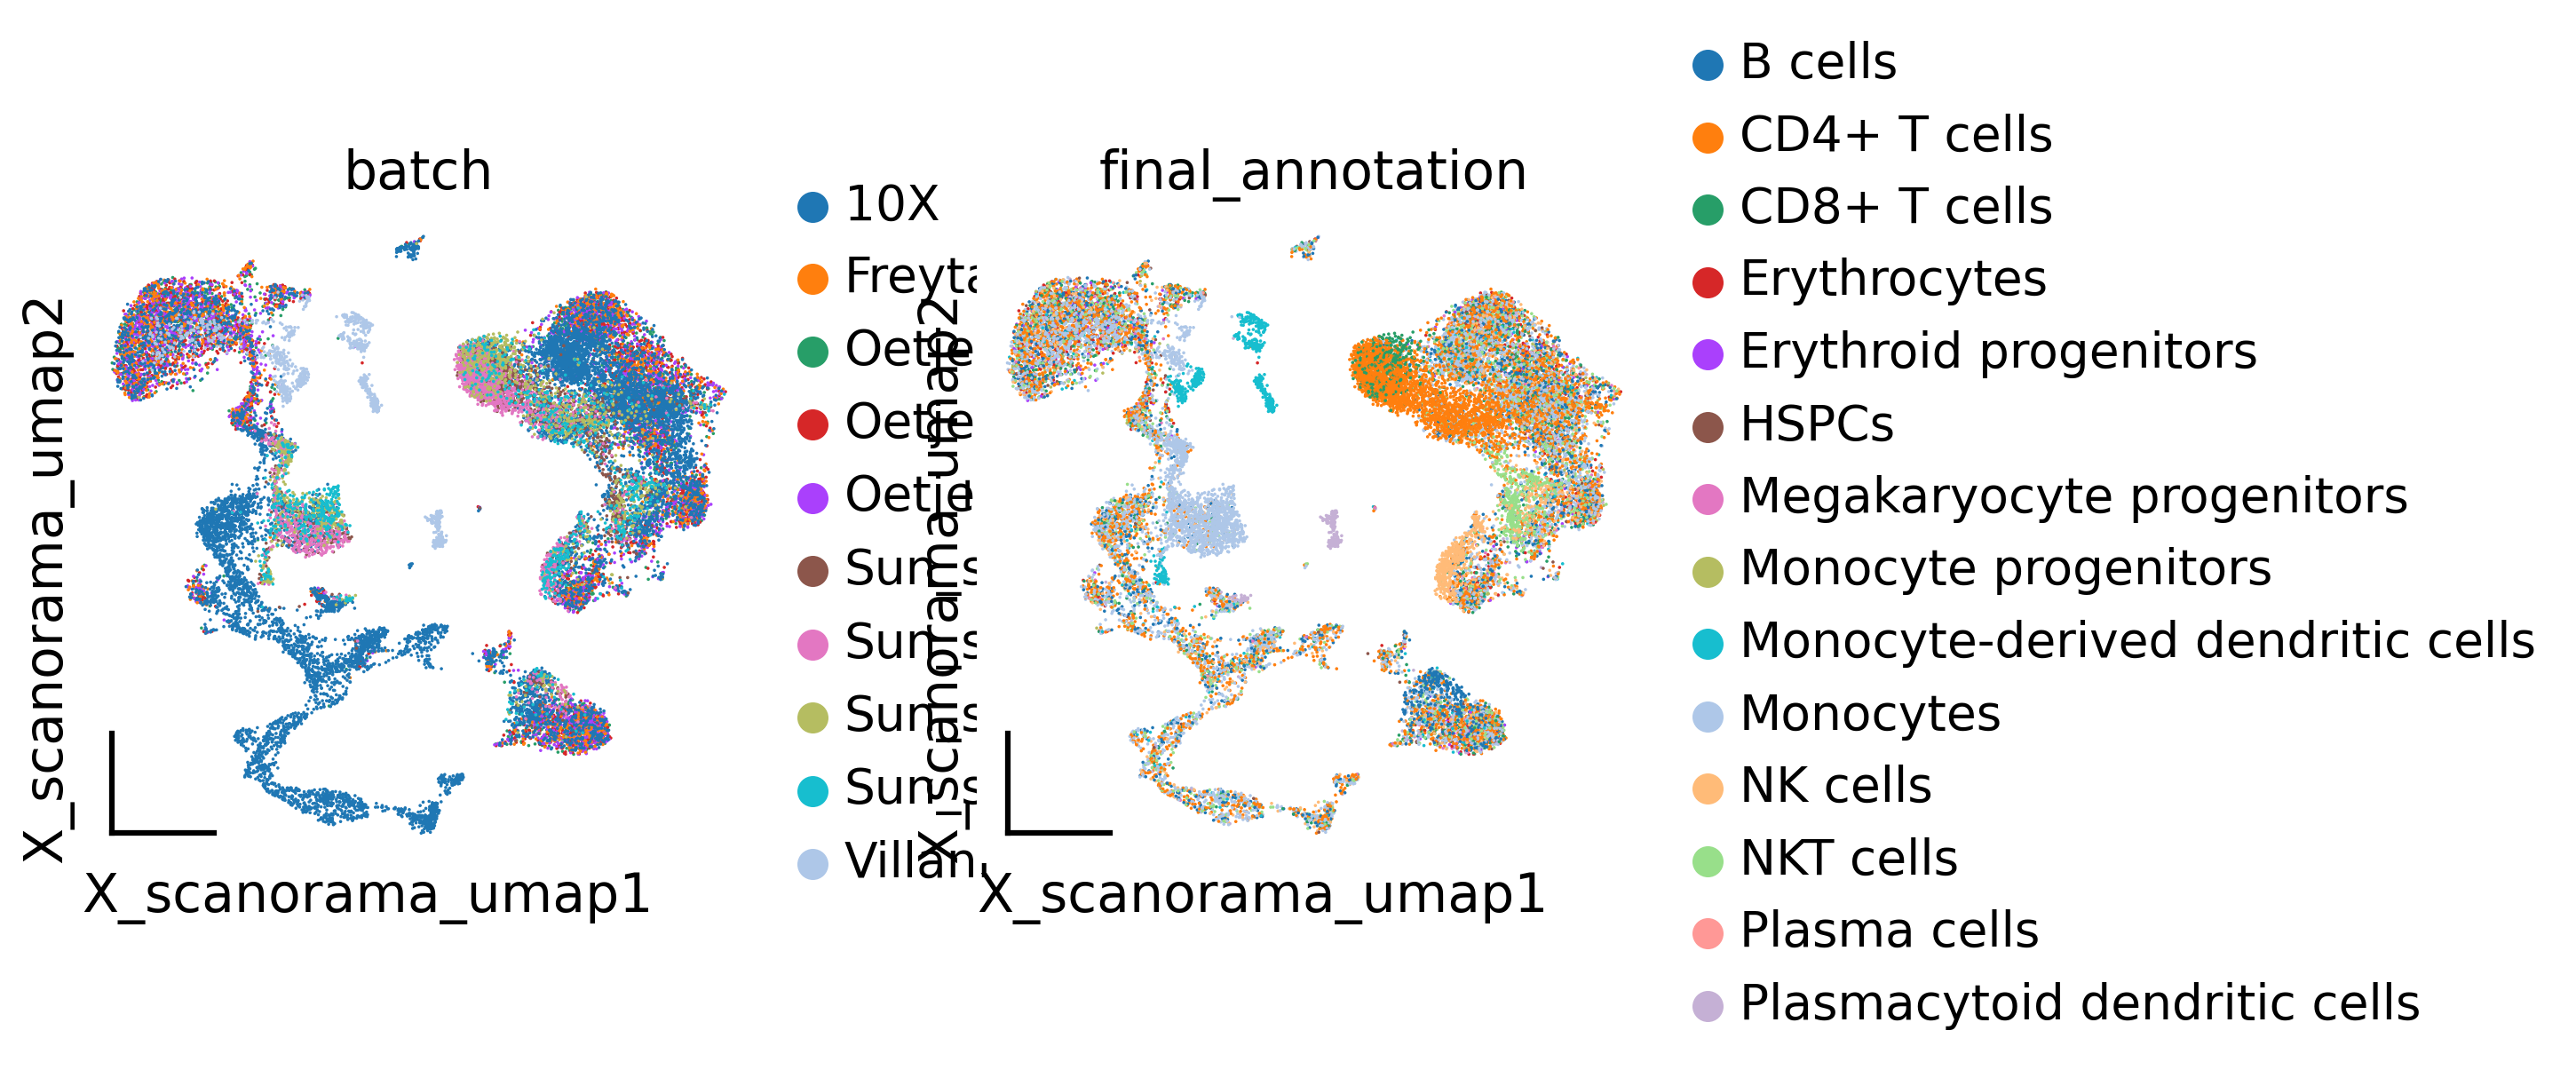

In [19]:
ov.utils.embedding(adata_scanorama,
                basis='X_scanorama_umap',frameon='small',
                color=['batch','final_annotation'],show=False)